In [10]:
# import your libraries here
import pandas as pd
import keras
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Input, InputLayer, Normalization
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error


In [37]:
data = pd.read_csv("processed_data.csv")
# print(data["Year"].value_counts())
data

,Country,Year,total_renewable_water_resources,agricultural_value_added_percent_of_gdp,total_exploitable_water_resources,precipitation_index,gdp_per_capita,total_internal_renewable_water_resource_per_capita,arable_land_area,total_population,total_yield
0,Albania,2018,30.2,18.429476,13.0,1136.00,5257.650696,9331.399988,611.346,2882.740,87.14
1,Albania,2017,30.2,19.022127,13.0,1136.00,4514.204908,9326.776621,612.000,2884.169,69.81
2,Albania,2016,30.2,19.849993,13.0,1136.00,4109.340457,9319.444935,620.300,2886.438,68.46
3,Albania,2015,30.2,19.780225,13.0,1136.00,3939.413126,9306.306528,615.100,2890.513,71.04
4,Albania,2014,30.2,19.990153,13.0,1136.00,4567.281443,9287.695875,615.600,2896.305,68.50
...,...,...,...,...,...,...,...,...,...,...,...
1915,Zimbabwe,1974,20.0,13.822747,1.5,746.72,811.510083,2014.765967,2465.000,6085.074,141.67
1916,Zimbabwe,1973,20.0,11.305693,1.5,712.18,698.192005,2085.840681,2415.000,5877.726,112.67
1917,Zimbabwe,1972,20.0,13.466776,1.5,677.64,588.037380,2160.767062,2415.000,5673.911,125.86
1918,Zimbabwe,1971,20.0,13.129246,1.5,643.10,493.287110,2238.459064,2385.000,5476.982,132.97


In [12]:
from time import time_ns

def get_X_and_y(df : pd.DataFrame, y_col_name:str) -> tuple[np.ndarray,np.ndarray]:
    X = df.copy()
    X.pop("Country")
    y = X.pop(y_col_name) 
    return X.__array__().astype("float32"), y.__array__().astype("float32")

def data_generator(X, y, batch_size: int) -> tuple[list,list]:
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    i = 0
    for i in range(0,len(y),batch_size):
        next_i = min(len(y), i+batch_size)
        features = X[i:next_i]
        y_true = y[i:next_i]
        yield features, y_true




In [13]:
# given lines of text (arraylike) and embeddings (model.wv)
def train_model(X,y, learning_rate = 0.01, epochs=100):
    # print(X)
    num_sequences_per_batch = 16 # this is the batch size
    steps_per_epoch = len(X)//num_sequences_per_batch  # Number of batches per epoch
    # train_generator = data_generator(X, y, num_sequences_per_batch)
    # sample=next(train_generator) # this is how you get data out of generators
    # print(sample)

    # Define the model architecture using Keras Sequential API
    model = Sequential()
    # setup normalization layer as input layer - DON'T TOUCH THIS LAYER
    normalizer = Normalization(input_shape=(X.shape[1],),axis=None)
    # adapt for our training input data
    normalizer.adapt(X)
    # add normalization layer to 
    model.add(normalizer)
    # configure and add hidden layers - TWEAK THESE LAYERS (modify, add, or remove)
    model.add(layer_h0 := Dense(3000, activation='relu'))
    model.add(layer_h1 := Dense(2500, activation='relu'))
    model.add(layer_h2 := Dense(2000, activation='relu'))
    model.add(layer_h3 := Dense(1500, activation='relu'))
    model.add(layer_h4 := Dense(1000, activation='relu'))
    # add output layer
    model.add(layer_o := Dense(1)) 
    # model.summary()

    # setup model for learning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='mean_absolute_error')
    
    # train the model
    model.fit(x=X, y=y,epochs=epochs)

    # return the model, tokenizer, and embedding dict for sentence generation use later
    return model

In [14]:
# split data into training and test
train_data = data.loc[data["Year"]!=2018,:]
test_data = data.loc[data["Year"]==2018,:]

# then get X and y for both training and test data (numpy arrays)
train_X,train_y = get_X_and_y(train_data,"total_yield")
test_X,test_y = get_X_and_y(test_data,"total_yield")
train_y

array([ 69.81,  68.46,  71.04, ..., 125.86, 132.97, 123.17], dtype=float32)

In [15]:
# m = train_model(train_X, train_y, learning_rate = 0.01, epochs=100)


In [16]:
# preds = [arr[0] for arr in m.predict(test_X)]
# # for yhat,y in zip(preds,test_y):
#     # print(f"predicted: {yhat} , y_true: {y}")
# print(mean_absolute_error(y_pred=preds,y_true=test_y))

## HYPER PARAMETER TUNING

In [17]:
import os

#Test out different learning rates
learning_rates = [0.0001,0.001,0.0025,0.005,0.01,0.025,0.05]
# learning_rates_models = []

# for i,rate in enumerate(learning_rates):
#     m = train_model(train_X, train_y, learning_rate = rate, epochs=100)
    # preds = [arr[0] for arr in m.predict(test_X)]
#     learning_rates_models[rate(mean_absolute_error(y_pred=preds,y_true=test_y))
    
#Test out different # of epochs
epochs_values = [1000,500,50,10] #,50,100,500,1000]
# epoch_values_models = []

# (learning_rate, epochs): model
# tuning_results_models = {}
model_files = [fn.replace("(","") for fn in os.listdir("tuning_results/") if "-model" in fn]
already_tuned_params = [(fn.split("-")[0],fn.split("-")[1]) for fn in model_files]
print(model_files)
print(already_tuned_params)
for lr in learning_rates: 
    for epochs in epochs_values:
        if not (str(lr),str(epochs)) in already_tuned_params:
            m = train_model(train_X, train_y, learning_rate = lr, epochs = epochs)
            # preds = [arr[0] for arr in m.predict(test_X)]
            # tuning_results_mae[(lr,epochs)] = mean_absolute_error(y_pred=preds,y_true=test_y)
            # tuning_results_models[(lr,epochs)] = m

            m.save(f'tuning_results/{lr}-{epochs}-model') 
            # pickle.dump(m, pickle_file)
        else:
            print(f'{lr}-{epochs} already trained')
            # m = keras.models.load_model("tuning_results/"+f"{lr}-{epochs}-model")
            # m = train_model(train_X, train_y, learning_rate = lr, epochs = epochs)



['0.005-50-model', '0.001-10-model', '0.001-1000-model', '0.0025-100-model', '0.0001-500-model', '0.001-50-model', '0.0001-10-model', '0.0001-100-model', '0.0025-1000-model', '0.025-50-model', '0.01-50-model', '0.05-50-model', '0.0025-10-model', '0.0001-1000-model', '0.0025-50-model', '0.025-10-model', '0.001-500-model', '0.005-500-model', '0.05-500-model', '0.05-10-model', '0.005-1000-model', '0.01-500-model', '0.0001-50-model', '0.025-100-model', '0.005-100-model', '0.0025-500-model', '0.025-500-model', '0.01-10-model', '0.025-1000-model', '0.001-100-model', '0.005-10-model', '0.05-100-model', '0.01-1000-model', '0.01-100-model']
[('0.005', '50'), ('0.001', '10'), ('0.001', '1000'), ('0.0025', '100'), ('0.0001', '500'), ('0.001', '50'), ('0.0001', '10'), ('0.0001', '100'), ('0.0025', '1000'), ('0.025', '50'), ('0.01', '50'), ('0.05', '50'), ('0.0025', '10'), ('0.0001', '1000'), ('0.0025', '50'), ('0.025', '10'), ('0.001', '500'), ('0.005', '500'), ('0.05', '500'), ('0.05', '10'), ('0

2023-04-09 18:31:23.647941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [ ]:
m = train_model(train_X, train_y, learning_rate = 0.001, epochs = 1000)
m.save(f'tuning_results/{lr}-{epochs}-big_model') 

Epoch 1/1000
59/59 [==============================] - 2s 22ms/step - loss: 43.6473
Epoch 2/1000
59/59 [==============================] - 1s 21ms/step - loss: 31.0423
Epoch 3/1000
59/59 [==============================] - 1s 21ms/step - loss: 28.1954
Epoch 4/1000
59/59 [==============================] - 1s 21ms/step - loss: 25.9386
Epoch 5/1000
59/59 [==============================] - 1s 22ms/step - loss: 25.1278
Epoch 6/1000
59/59 [==============================] - 1s 22ms/step - loss: 23.9134
Epoch 7/1000
59/59 [==============================] - 1s 23ms/step - loss: 24.1185
Epoch 8/1000
59/59 [==============================] - 1s 25ms/step - loss: 23.6978
Epoch 9/1000
59/59 [==============================] - 1s 22ms/step - loss: 23.1862
Epoch 10/1000
59/59 [==============================] - 1s 23ms/step - loss: 22.0230
Epoch 11/1000
59/59 [==============================] - 1s 21ms/step - loss: 21.5915
Epoch 12/1000
59/59 [==============================] - 1s 21ms/step - loss: 21.8715
E

In [ ]:
tuning_results = []
# all_X, all_y = get_X_and_y(data, "total_yield")
# data.sample(frac=1)
model_files = [fn for fn in os.listdir("tuning_results/") if "-model" in fn] + ["0.001-1000-big_model"]
already_tuned_params = [(fn.split("-")[0],fn.split("-")[1]) for fn in model_files]
for model_file, params in zip(model_files,already_tuned_params):
    m = keras.models.load_model("tuning_results/"+model_file)
    preds = [arr[0] for arr in m.predict(test_X)]
    tuning_results.append({
        "learning_rate":params[0],
        "epochs":params[1],
        "MAE": mean_absolute_error(y_pred=preds,y_true=test_y),
        "MSE": mean_squared_error(y_pred=preds, y_true=test_y),
        "R2": r2_score(y_pred=preds, y_true=test_y),
        "big_model": "big_model" in model_file
        })
tuning_results_df = pd.DataFrame(tuning_results)


2/2 [==============================] - 0s 3ms/step


In [ ]:
tuning_results_df.sort_values("MSE",ascending=True, inplace=True)
tuning_results_df

,learning_rate,epochs,MAE,MSE,R2,big_model
34,0.001,1000,5.872686,95.266403,0.958141,True
13,0.0001,1000,6.728926,112.647369,0.950504,False
2,0.001,1000,6.290426,114.635590,0.949630,False
8,0.0025,1000,6.650530,120.276176,0.947151,False
20,0.005,1000,6.624895,143.829178,0.936802,False
21,0.01,500,7.426500,150.346909,0.933939,False
16,0.001,500,7.309906,151.379929,0.933485,False
17,0.005,500,8.058887,158.869766,0.930194,False
25,0.0025,500,7.591632,168.580124,0.925927,False
4,0.0001,500,9.337980,189.253235,0.916843,False


60/60 [==============================] - 0s 4ms/step


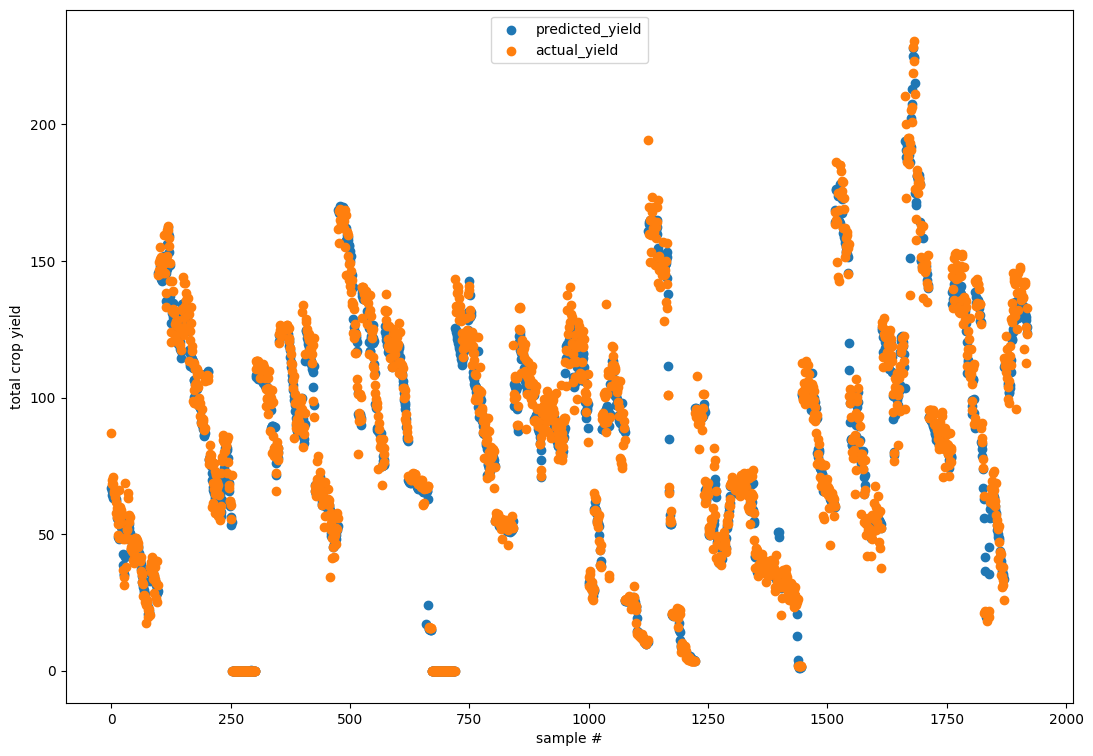

In [18]:
def plot_actual_vs_predicted_yield(data: pd.DataFrame, model):
    # then get X and y for both training and test data (numpy arrays)
    X,y = get_X_and_y(data,"total_yield")
    
    plt.figure(figsize = (13,9))
    plt.scatter(np.arange(0, len(X)), [pred[0] for pred in best_model.predict(X)], label="predicted_yield")
    plt.scatter(np.arange(0, len(y)), y, label="actual_yield")
    leg = plt.legend(loc='upper center')
    plt.xlabel('sample #')
    plt.ylabel('total crop yield')
    plt.rc('font', size=15)
    plt.show()
best_model = keras.models.load_model("tuning_results/0.001-1000-big_model/")
plot_actual_vs_predicted_yield(data=data, model=best_model)

In [36]:
feature_testing = []
# all_X, all_y = get_X_and_y(data, "total_yield")
# data.sample(frac=1)
for column in data.columns:
    if not column in ("total_yield", "Country"):
        print(column)
        # dropped_data = data.copy()
        # dropped_data.drop(columns=[column],inplace=False)
        dropped_data = data.copy()
        dropped_test_data = dropped_data.copy().loc[dropped_data["Year"]==2018,:]
        dropped_test_data[column] = dropped_test_data[column].apply(lambda x:0)
        dropped_test_X,dropped_test_y = get_X_and_y(dropped_test_data,"total_yield")
        preds = [arr[0] for arr in best_model.predict(dropped_test_X)]

        feature_testing.append({
            "column_dropped": column,
            "MAE": mean_absolute_error(y_pred=preds,y_true=dropped_test_y),
            "MSE": mean_squared_error(y_pred=preds, y_true=dropped_test_y),
            "R2": r2_score(y_pred=preds, y_true=dropped_test_y),
            })

# split data into training and test
# train_data = data.loc[data["Year"]!=2018,:]
# test_data = data.loc[data["Year"]==2018,:]

# # then get X and y for both training and test data (numpy arrays)
# train_X,train_y = get_X_and_y(train_data,"total_yield")
# test_X,test_y = get_X_and_y(test_data,"total_yield")

feature_testing_df = pd.DataFrame(feature_testing)
feature_testing_df.sort_values("MSE",ascending=False, inplace=True)

feature_testing_df

Year
2/2 [==============================] - 0s 4ms/step
total_renewable_water_resources
2/2 [==============================] - 0s 4ms/step
agricultural_value_added_percent_of_gdp
2/2 [==============================] - 0s 4ms/step
total_exploitable_water_resources
2/2 [==============================] - 0s 4ms/step
precipitation_index
2/2 [==============================] - 0s 4ms/step
gdp_per_capita
2/2 [==============================] - 0s 4ms/step
total_internal_renewable_water_resource_per_capita
2/2 [==============================] - 0s 6ms/step
arable_land_area
2/2 [==============================] - 0s 4ms/step
total_population
2/2 [==============================] - 0s 4ms/step


,column_dropped,MAE,MSE,R2
8,total_population,74.501221,7501.771973,-2.296226
7,arable_land_area,29.942402,2279.839355,-0.001745
5,gdp_per_capita,33.680569,2200.368896,0.033174
6,total_internal_renewable_water_resource_per_ca...,26.643768,1774.101929,0.220472
4,precipitation_index,7.994321,185.911926,0.918312
0,Year,7.286839,148.410294,0.934790
1,total_renewable_water_resources,5.863059,95.442268,0.958063
3,total_exploitable_water_resources,5.861855,95.333519,0.958111
2,agricultural_value_added_percent_of_gdp,5.873668,95.314209,0.958120
